In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot

In [2]:
model_num = 1
phase = 0


model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='try6')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

Directory '/Users/mahdiyarshahbazi/Documents/Data/MotorNet/try6' already exists.


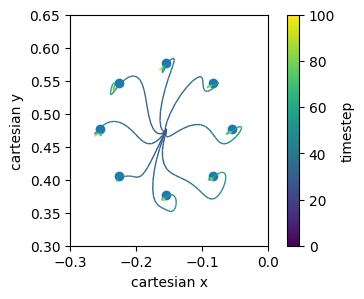

In [3]:
xy, tg, all_hidden, all_actions = test(cfg_file,weight_file,ff_coefficient=0)
fig, ax  = plot.plot_simulations(xy=xy,target_xy=tg)

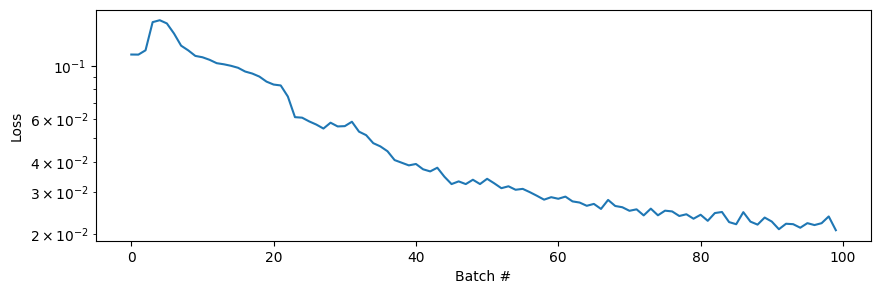

In [4]:
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log=log)

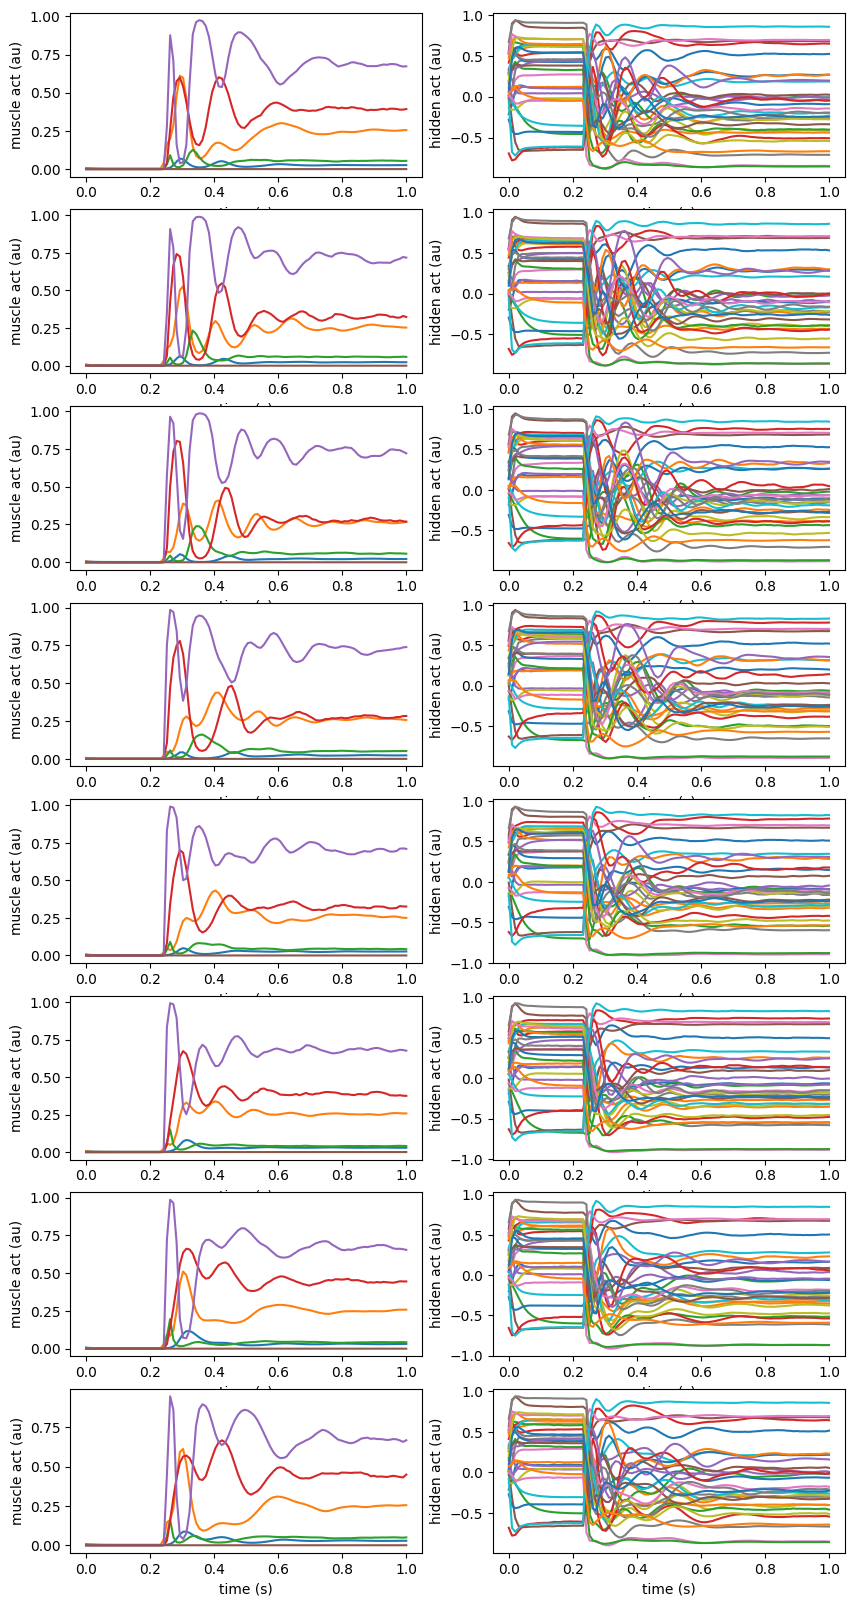

In [5]:
fig, ax = plot.plot_activation(all_hidden, all_actions)
#fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)

In [12]:
# Perform PCA on network hidden units trajectories
from latent_analysis import LTransform as LT
import numpy as np

In [13]:
all_hidden = np.array(all_hidden)

In [15]:
all_hidden.shape

(8, 100, 32)

In [19]:
n_mean = np.mean(all_hidden, axis=0, keepdims=True)
rate_scaled = (all_hidden - n_mean)


In [20]:
transform = LT.Transform(num_latent=3)


In [32]:
transform.fit(rate_scaled, method='FA')


In [33]:
X_ld = transform.transform(rate_scaled, ensure_orthogonality=True)


In [34]:
X_ld.shape

(8, 100, 3)

In [25]:
import matplotlib.pyplot as plt

In [26]:
angle_set = np.deg2rad(np.arange(0,360,45)) # 8 directions

In [27]:
angle_set

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714])

In [28]:
reach_angles = []
for cond in angle_set:
    reach_angles.append(plt.cm.brg(cond / (2*np.pi) + 0.5))


In [29]:
reach_angles

[(0.996078431372549, 0.00392156862745098, 0.0, 1.0),
 (0.7450980392156863, 0.2549019607843137, 0.0, 1.0),
 (0.49411764705882355, 0.5058823529411764, 0.0, 1.0),
 (0.2431372549019608, 0.7568627450980392, 0.0, 1.0),
 (0.0, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.0, 1.0)]

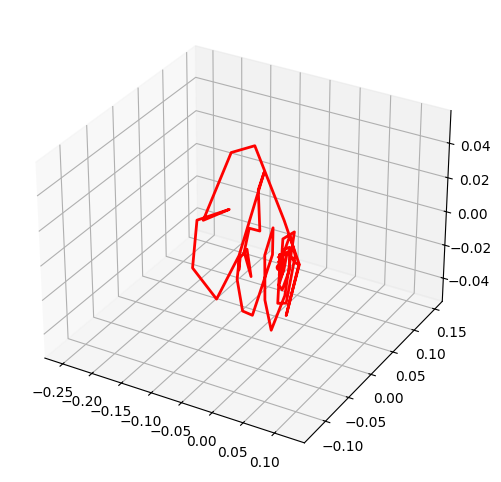

In [35]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for c in range(1):
    ax.plot(X_ld[c, :, 0], X_ld[c,:, 1], X_ld[c,:, 2], lw=2, c=reach_angles[c])
    ax.scatter(X_ld[c,0, 0], X_ld[c,0, 1], X_ld[c,0, 2], color=reach_angles[c])
    ax.scatter(X_ld[c,-1, 0], X_ld[c,-1, 1], X_ld[c,-1, 2], marker = 'x' ,color=reach_angles[c])